# Basic Coding With SHARPpy

Written by: Greg Blumberg (OU/CIMMS)

#### This IPython Notebook tutorial is meant to teach the user how to directly interact with the SHARPpy libraries using the Python interpreter.  This tutorial will cover reading in files into the the Profile object, plotting the data using Matplotlib, and computing various indices from the data.  It is also a reference to the different functions and variables SHARPpy has available to the user.

To work your way through this notebook, you should run each code cell by pressing "Shift-Enter" on your keyboard.

In order to work with SHARPpy, you need to perform 3 steps before you can begin running routines such as CAPE/CIN on the data.

### Step 1: Read in the data to work with.

1.) The Pilger, NE tornado proximity sounding from 19 UTC within the tutorial/ directory is an example of the SPC sounding file format that can be read in by the GUI.  Here we'll read it in manually.

If you want to read in your own data using this function, write a script to mimic the data format shown in the 14061619.OAX file found in this directory.  Missing values must be -9999.

In [13]:
%matplotlib inline
spc_file = open('14061619.OAX', 'r').read()

### Step 2: Load in the SHARPTAB module.

All of the SHARPpy routines (parcel lifting, composite indices, etc.) reside within the SHARPTAB module.

SHARPTAB contains 6 modules:
params, winds, thermo, utils, interp, fire, constants, watch_type

Each module has different functions:

    interp - interpolates different variables (temperature, dewpoint, wind, etc.) to a specified pressure
    winds - functions used to compute different wind-related variables (shear, helicity, mean winds, storm relative vectors)
    thermo - temperature unit conversions, theta-e, theta, wetbulb, lifting functions
    utils - wind speed unit conversions, wind speed and direction to u and v conversions, QC
    params - computation of different parameters, indices, etc. from the Profile object
    fire - fire weather indices
 
Below is the code to load in these modules:

In [4]:
import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

/Users/blumberg/anaconda/lib/python2.7/site-packages/SHARPpy-1.4.0-py2.7.egg/sharppy/sharptab/winds.py:14: UserWarning: Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)
  warnings.warn("Future versions of the routines in the winds module may include options to use height values instead of pressure to specify layers (i.e. SRH, wind shear, etc.)")


### Step 3: Making a Profile object.

Before running any analysis routines on the data, we have to create a Profile object first.  A Profile object describes the vertical thermodynamic and kinematic profiles and is the key object that all SHARPpy routines need to run.  Any data source can be passed into a Profile object (i.e. radiosonde, RASS, satellite sounding retrievals, etc.) as long as it has these profiles:

- temperature (C)
- dewpoint (C)
- height (meters above mean sea level)
- pressure (millibars)
- wind speed (kts)
- wind direction (degrees)

or (optional)
- zonal wind component U (kts)
- meridional wind component V (kts)

For example, after reading in the data in the example above, a Profile object can be created.  Since this file uses the value -9999 to indicate missing values, we need to tell SHARPpy to ignore these values in its calculations by including the missing field to be -9999.  In addition, we tell SHARPpy we want to create a default BasicProfile object.  Telling SHARPpy to create a "convective" profile object instead of a "default" profile object will generate a Profile object with all of the indices computed in the SHARPpy GUI.  If you are only wanting to compute a few indices, you probably don't want to do that.

In [14]:
import numpy as np
from StringIO import StringIO

def parseSPC(spc_file):
    """
        This function will read a SPC-style formatted observed sounding file,
        similar to that of the 14061619.OAX file included in the SHARPpy distribution.
        
        It will return the pressure, height, temperature, dewpoint, wind direction and wind speed data
        from that file.
    """
    ## read in the file
    data = np.array([l.strip() for l in spc_file.split('\n')])

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0] + 1
    finish_idx = np.where( data == '%END%')[0]

    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )

    return p, h, T, Td, wdir, wspd

pres, hght, tmpc, dwpc, wdir, wspd = parseSPC(spc_file)

prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, wspd=wspd, wdir=wdir, missing=-9999, strictQC=True)

/Users/blumberg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In SHARPpy, Profile objects have quality control checks built into them to alert the user to bad data and in order to prevent the program from crashing on computational routines.  For example, upon construction of the Profile object, the SHARPpy will check for unrealistic values (i.e. dewpoint or temperature below absolute zero, negative wind speeds) and incorrect ordering of the height and pressure arrays.  Height arrays must be increasing with array index, and pressure arrays must be decreasing with array index.  Repeat values are not allowed.  

If you encounter this issue, you can either manually edit the data to remove the offending data values or you can avoid these checks by setting the "strictQC" flag to False when constructing an object.

Because Python is an interpreted language, it can be quite slow for certain processes.  When working with soundings in SHARPpy, we recommend the profiles contain a maximum of 200-500 points.  High resolution radiosonde profiles (i.e. 1 second profiles) contain thousands of points and some of the SHARPpy functions that involve lifting parcels (i.e. parcelx) may take a long time to run.  To filter your data to make it easier for SHARPpy to work with, you can use a sounding filter such as the one found here:

https://github.com/tsupinie/SoundingFilter

### Let's view the data that's in the Profile object real quick.

Do do this, we'll make a for loop to loop over all of the data within the Profile object and print the data out for each line.  Missing values will be denoted by "--" instead of -9999.  This is a consquence of the data being read in by the Profile object framework.

In [15]:
for i in range(len(prof.hght)):
    print prof.pres[i], prof.hght[i], prof.tmpc[i], prof.dwpc[i], prof.wdir[i], prof.wdir[i]

1000.0 34.0 -- -- -- --
965.0 350.0 27.8 23.8 150.0 150.0
962.0 377.51 27.4 22.8 -- --
936.87 610.0 25.51 21.72 145.0 145.0
925.0 722.0 24.6 21.2 150.0 150.0
904.95 914.0 23.05 20.43 160.0 160.0
889.0 1069.78 21.8 19.8 -- --
877.0 1188.26 22.2 17.3 -- --
873.9 1219.0 22.02 16.98 175.0 175.0
853.0 1429.46 20.8 14.8 -- --
850.0 1460.0 21.0 14.0 180.0 180.0
844.0 1521.47 21.4 11.4 -- --
814.51 1829.0 19.63 8.65 195.0 195.0
814.0 1834.46 19.6 8.6 -- --
805.0 1930.24 18.8 13.8 -- --
794.0 2048.59 18.0 13.5 -- --
786.13 2134.0 17.57 12.72 200.0 200.0
783.0 2168.27 17.4 12.4 -- --
761.0 2411.82 16.4 7.4 -- --
758.66 2438.0 16.49 5.16 210.0 210.0
756.0 2467.98 16.6 2.6 -- --
743.0 2615.49 16.0 -1.0 -- --
737.0 2684.28 15.4 -0.6 -- --
731.9 2743.0 14.64 2.45 210.0 210.0
729.0 2776.65 14.2 4.2 -- --
710.0 2999.06 12.2 4.2 -- --
705.87 3048.0 11.99 3.99 210.0 210.0
702.0 3094.1 11.8 3.8 -- --
700.0 3118.0 11.6 2.6 215.0 215.0
697.0 3153.92 11.6 0.6 -- --
682.0 3335.5 10.4 2.4 -- --
675.0 3421.38 

## Working with the data:

Once you have a Profile object, you can begin running analysis routines and plotting the data.  The following sections show different examples of how to do this.

### Plotting the data:

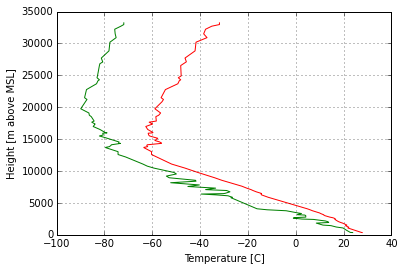

In [16]:
import matplotlib.pyplot as plt
plt.plot(prof.tmpc, prof.hght, 'r-')
plt.plot(prof.dwpc, prof.hght, 'g-')
#plt.barbs(40*np.ones(len(prof.hght)), prof.hght, prof.u, prof.v)
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.grid()
plt.show()

SHARPpy Profile objects keep track of the height grid the profile lies on.  Within the profile object, the height grid is assumed to be in meters above mean sea level.

In the example data provided, the profile can be converted to and from AGL from MSL:

In [17]:
msl_hght = prof.hght[prof.sfc] # Grab the surface height value
print "SURFACE HEIGHT (m MSL):",msl_hght
agl_hght = interp.to_agl(prof, msl_hght) # Converts to AGL
print "SURFACE HEIGHT (m AGL):", agl_hght
msl_hght = interp.to_msl(prof, agl_hght) # Converts to MSL
print "SURFACE HEIGHT (m MSL):",msl_hght

SURFACE HEIGHT (m MSL): 350.0
SURFACE HEIGHT (m AGL): 0.0
SURFACE HEIGHT (m MSL): 350.0


### Showing derived profiles:

By default, Profile objects also create derived profiles such as Theta-E and Wet-Bulb when they are constructed. These profiles are accessible to the user too.

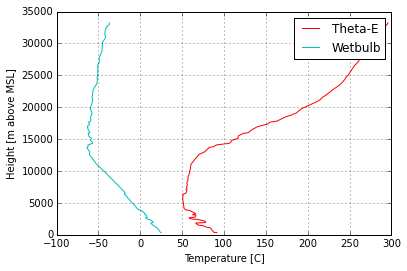

In [9]:
plt.plot(thermo.ktoc(prof.thetae), prof.hght, 'r-', label='Theta-E')
plt.plot(prof.wetbulb, prof.hght, 'c-', label='Wetbulb')
plt.xlabel("Temperature [C]")
plt.ylabel("Height [m above MSL]")
plt.legend()
plt.grid()
plt.show()

### Lifting Parcels:

In SHARPpy, parcels are lifted via the params.parcelx() routine.  The parcelx() routine takes in the arguments of a Profile object and a flag to indicate what type of parcel you would like to be lifted.  Additional arguments can allow for custom/user defined parcels to be passed to the parcelx() routine, however most users will likely be using only the Most-Unstable, Surface, 100 mb Mean Layer, and Forecast parcels.

The parcelx() routine by default utilizes the virtual temperature correction to compute variables such as CAPE and CIN.  If the dewpoint profile contains missing data, parcelx() will disregard using the virtual temperature correction.

In [10]:
sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
fcstpcl = params.parcelx( prof, flag=2 ) # Forecast Parcel
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

/Users/keltonhalbert/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


Once your parcel attributes are computed by params.parcelx(), you can extract information about the parcel such as CAPE, CIN, LFC height, LCL height, EL height, etc.

In [11]:
print "Most-Unstable CAPE:", mupcl.bplus # J/kg
print "Most-Unstable CIN:", mupcl.bminus # J/kg
print "Most-Unstable LCL:", mupcl.lclhght # meters AGL
print "Most-Unstable LFC:", mupcl.lfchght # meters AGL
print "Most-Unstable EL:", mupcl.elhght # meters AGL
print "Most-Unstable LI:", mupcl.li5 # C

Most-Unstable CAPE: 5769.22545311
Most-Unstable CIN: -0.644692447001
Most-Unstable LCL: 512.718558828
Most-Unstable LFC: 612.53643485
Most-Unstable EL: 13882.5821154
Most-Unstable LI: -13.8145334959


### Other Parcel Object Attributes:

The six indices listed above are not the only ones calculated by parcelx().  Other indices can be calculated and accessed too:

Here is a list of the attributes and their units contained in each parcel object (pcl):

    pcl.pres - Parcel beginning pressure (mb)
    pcl.tmpc - Parcel beginning temperature (C)
    pcl.dwpc - Parcel beginning dewpoint (C)
    pcl.ptrace - Parcel trace pressure (mb)
    pcl.ttrace - Parcel trace temperature (C)
    pcl.blayer - Pressure of the bottom of the layer the parcel is lifted (mb)
    pcl.tlayer - Pressure of the top of the layer the parcel is lifted (mb)
    pcl.lclpres - Parcel LCL (lifted condensation level) pressure (mb)
    pcl.lclhght - Parcel LCL height (m AGL)
    pcl.lfcpres - Parcel LFC (level of free convection) pressure (mb)
    pcl.lfchght - Parcel LFC height (m AGL)
    pcl.elpres - Parcel EL (equilibrium level) pressure (mb)
    pcl.elhght - Parcel EL height (m AGL)
    pcl.mplpres - Maximum Parcel Level (mb)
    pcl.mplhght - Maximum Parcel Level (m AGL)
    pcl.bplus - Parcel CAPE (J/kg)
    pcl.bminus - Parcel CIN (J/kg)
    pcl.bfzl - Parcel CAPE up to freezing level (J/kg)
    pcl.b3km - Parcel CAPE up to 3 km (J/kg)
    pcl.b6km - Parcel CAPE up to 6 km (J/kg)
    pcl.p0c - Pressure value at 0 C  (mb)
    pcl.pm10c - Pressure value at -10 C (mb)
    pcl.pm20c - Pressure value at -20 C (mb)
    pcl.pm30c - Pressure value at -30 C (mb)
    pcl.hght0c - Height value at 0 C (m AGL)
    pcl.hghtm10c - Height value at -10 C (m AGL)
    pcl.hghtm20c - Height value at -20 C (m AGL)
    pcl.hghtm30c - Height value at -30 C (m AGL)
    pcl.wm10c - Wet bulb velocity at -10 C 
    pcl.wm20c - Wet bulb velocity at -20 C
    pcl.wm30c - Wet bulb at -30 C
    pcl.li5 = - Lifted Index at 500 mb (C)
    pcl.li3 = - Lifted Index at 300 mb (C)
    pcl.brnshear - Bulk Richardson Number Shear
    pcl.brnu - Bulk Richardson Number U (kts)
    pcl.brnv - Bulk Richardson Number V (kts)
    pcl.brn - Bulk Richardson Number (unitless)
    pcl.limax - Maximum Lifted Index (C)
    pcl.limaxpres - Pressure at Maximum Lifted Index (mb)
    pcl.cap - Cap Strength (C)
    pcl.cappres - Cap strength pressure (mb)
    pcl.bmin - Buoyancy minimum in profile (C)
    pcl.bminpres - Buoyancy minimum pressure (mb)

### Adding a Parcel Trace and plotting Moist and Dry Adiabats:

Now, let's try to plot the data on a Skew-T.  You may want to do this if you're looking to create a plot for use in a publication.

First, we need to tell Matplotlib (the Python plotting package) that we'd like a Skew-T style plot.  The code in the following cell allow us to do this.  This code was lifted from: http://matplotlib.org/examples/api/skewt.html

In [ ]:
# This serves as an intensive exercise of matplotlib's transforms
# and custom projection API. This example produces a so-called
# SkewT-logP diagram, which is a common plot in meteorology for
# displaying vertical profiles of temperature. As far as matplotlib is
# concerned, the complexity comes from having X and Y axes that are
# not orthogonal. This is handled by including a skew component to the
# basic Axes transforms. Additional complexity comes in handling the
# fact that the upper and lower X-axes have different data ranges, which
# necessitates a bunch of custom classes for ticks,spines, and the axis
# to handle this.

from matplotlib.axes import Axes
import matplotlib.transforms as transforms
import matplotlib.axis as maxis
import matplotlib.spines as mspines
import matplotlib.path as mpath
from matplotlib.projections import register_projection

# The sole purpose of this class is to look at the upper, lower, or total
# interval as appropriate and see what parts of the tick to draw, if any.
class SkewXTick(maxis.XTick):
    def draw(self, renderer):
        if not self.get_visible(): return
        renderer.open_group(self.__name__)

        lower_interval = self.axes.xaxis.lower_interval
        upper_interval = self.axes.xaxis.upper_interval

        if self.gridOn and transforms.interval_contains(
                self.axes.xaxis.get_view_interval(), self.get_loc()):
            self.gridline.draw(renderer)

        if transforms.interval_contains(lower_interval, self.get_loc()):
            if self.tick1On:
                self.tick1line.draw(renderer)
            if self.label1On:
                self.label1.draw(renderer)

        if transforms.interval_contains(upper_interval, self.get_loc()):
            if self.tick2On:
                self.tick2line.draw(renderer)
            if self.label2On:
                self.label2.draw(renderer)

        renderer.close_group(self.__name__)


# This class exists to provide two separate sets of intervals to the tick,
# as well as create instances of the custom tick
class SkewXAxis(maxis.XAxis):
    def __init__(self, *args, **kwargs):
        maxis.XAxis.__init__(self, *args, **kwargs)
        self.upper_interval = 0.0, 1.0

    def _get_tick(self, major):
        return SkewXTick(self.axes, 0, '', major=major)

    @property
    def lower_interval(self):
        return self.axes.viewLim.intervalx

    def get_view_interval(self):
        return self.upper_interval[0], self.axes.viewLim.intervalx[1]


# This class exists to calculate the separate data range of the
# upper X-axis and draw the spine there. It also provides this range
# to the X-axis artist for ticking and gridlines
class SkewSpine(mspines.Spine):
    def _adjust_location(self):
        trans = self.axes.transDataToAxes.inverted()
        if self.spine_type == 'top':
            yloc = 1.0
        else:
            yloc = 0.0
        left = trans.transform_point((0.0, yloc))[0]
        right = trans.transform_point((1.0, yloc))[0]

        pts  = self._path.vertices
        pts[0, 0] = left
        pts[1, 0] = right
        self.axis.upper_interval = (left, right)


# This class handles registration of the skew-xaxes as a projection as well
# as setting up the appropriate transformations. It also overrides standard
# spines and axes instances as appropriate.
class SkewXAxes(Axes):
    # The projection must specify a name.  This will be used be the
    # user to select the projection, i.e. ``subplot(111,
    # projection='skewx')``.
    name = 'skewx'

    def _init_axis(self):
        #Taken from Axes and modified to use our modified X-axis
        self.xaxis = SkewXAxis(self)
        self.spines['top'].register_axis(self.xaxis)
        self.spines['bottom'].register_axis(self.xaxis)
        self.yaxis = maxis.YAxis(self)
        self.spines['left'].register_axis(self.yaxis)
        self.spines['right'].register_axis(self.yaxis)

    def _gen_axes_spines(self):
        spines = {'top':SkewSpine.linear_spine(self, 'top'),
                  'bottom':mspines.Spine.linear_spine(self, 'bottom'),
                  'left':mspines.Spine.linear_spine(self, 'left'),
                  'right':mspines.Spine.linear_spine(self, 'right')}
        return spines

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        rot = 30

        #Get the standard transform setup from the Axes base class
        Axes._set_lim_and_transforms(self)

        # Need to put the skew in the middle, after the scale and limits,
        # but before the transAxes. This way, the skew is done in Axes
        # coordinates thus performing the transform around the proper origin
        # We keep the pre-transAxes transform around for other users, like the
        # spines for finding bounds
        self.transDataToAxes = self.transScale + (self.transLimits +
                transforms.Affine2D().skew_deg(rot, 0))

        # Create the full transform from Data to Pixels
        self.transData = self.transDataToAxes + self.transAxes

        # Blended transforms like this need to have the skewing applied using
        # both axes, in axes coords like before.
        self._xaxis_transform = (transforms.blended_transform_factory(
                    self.transScale + self.transLimits,
                    transforms.IdentityTransform()) +
                transforms.Affine2D().skew_deg(rot, 0)) + self.transAxes
        
# Now register the projection with matplotlib so the user can select it.
register_projection(SkewXAxes)

Now that Matplotlib knows about the Skew-T style plot, let's plot the OAX sounding data on the Skew-T along with the Most-Unstable parcel trace.  Let's also include dry adiabats and moist adiabats for the user.

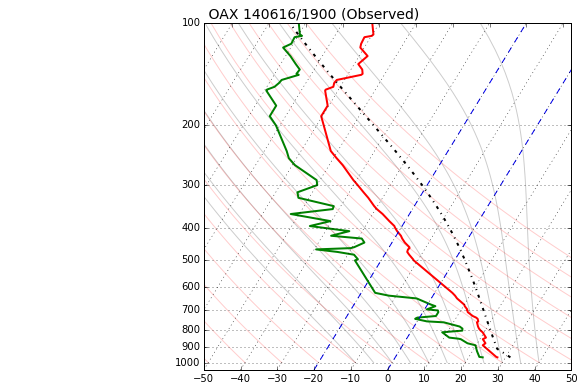

In [12]:
# Select the Most-Unstable parcel (this can be changed)
pcl = mupcl

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

# Let's set the y-axis bounds of the plot.
pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats at surface temperatures -10 C to 45 C at 5 degree intervals.
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    # Plot the moist-adiabat with a black line that is faded a bit.
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

# A function to calculate the dry adiabats
def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

# plot the title.
plt.title(' OAX 140616/1900 (Observed)', fontsize=14, loc='left')

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2)
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2)

# Plot the parcel trace.
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2)

# Denote the 0 to -20 C area on the Skew-T.
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Set the log-scale formatting and label the y-axis tick marks.
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)

# Label the x-axis tick marks.
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-50,50)

# Show the plot to the user.
# plt.savefig('skewt.png', bbox_inches='tight') # saves the plot to the disk.
plt.show()
    

### Calculating Kinematic Variables:

SHARPpy also allows the user to compute kinematic variables such as shear, mean-winds, and storm relative helicity.  SHARPpy will also compute storm motion vectors based off of the work by Stephen Corfidi and Matthew Bunkers.  Below is some example code to compute the following:

1.) 0-3 km Pressure-Weighted Mean Wind

2.) 0-6 km Shear (kts)

3.) Bunker's Storm Motion (right-mover) (Bunkers et al. 2014 version)

4.) Bunker's Storm Motion (left-mover) (Bunkers et al. 2014 version)

5.) 0-3 Storm Relative Helicity


In [17]:
# Find the pressure values that correspond to the surface, 1 km, 3 km and 6 km levels.
sfc = prof.pres[prof.sfc]
p3km = interp.pres(prof, interp.to_msl(prof, 3000.))
p6km = interp.pres(prof, interp.to_msl(prof, 6000.))
p1km = interp.pres(prof, interp.to_msl(prof, 1000.))

# Calculate the 0-3 km pressure-weighted mean wind
mean_3km = winds.mean_wind(prof, pbot=sfc, ptop=p3km)
print "0-3 km Pressure-Weighted Mean Wind (kt):", utils.comp2vec(mean_3km[0], mean_3km[1])[1]

# Calculate the 0-1, 0-3, and 0-6 km wind shear
sfc_6km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p6km)
sfc_3km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p3km)
sfc_1km_shear = winds.wind_shear(prof, pbot=sfc, ptop=p1km)
print "0-6 km Shear (kt):", utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1]

# Calculate the Bunkers Storm Motion Left and Right mover vectors (these are returned in u,v space
# so let's transform them into wind speed and direction space.)
srwind = params.bunkers_storm_motion(prof)
print "Bunker's Storm Motion (right-mover) [deg,kts]:", utils.comp2vec(srwind[0], srwind[1])
print "Bunker's Storm Motion (left-mover) [deg,kts]:", utils.comp2vec(srwind[2], srwind[3])

# Calculate the storm-relative helicity using the right-movers 
srh3km = winds.helicity(prof, 0, 3000., stu = srwind[0], stv = srwind[1])
srh1km = winds.helicity(prof, 0, 1000., stu = srwind[0], stv = srwind[1])
print "0-3 km Storm Relative Helicity [m2/s2]:",srh3km[0]

0-3 km Pressure-Weighted Mean Wind (kt): 41.1397595603
0-6 km Shear (kt): 55.9608928026
Bunker's Storm Motion (right-mover) [deg,kts]: (masked_array(data = 225.652934838,
             mask = False,
       fill_value = -9999.0)
, 27.240749559186799)
Bunker's Storm Motion (left-mover) [deg,kts]: (masked_array(data = 204.774711769,
             mask = False,
       fill_value = -9999.0)
, 52.946150880598658)
0-3 km Storm Relative Helicity [m2/s2]: 584.016767705


### Calculating variables based off of the effective inflow layer:

The effective inflow layer concept is used to obtain the layer of buoyant parcels that feed a storm's inflow.  Here are a few examples of how to compute variables that require the effective inflow layer in order to calculate them:

In [18]:
# Let's calculate the effective inflow layer and print out the heights of the top
# and bottom of the layer.  We'll have to convert it from m MSL to m AGL.
eff_inflow = params.effective_inflow_layer(prof)
ebot_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[0]))
etop_hght = interp.to_agl(prof, interp.hght(prof, eff_inflow[1]))
print "Effective Inflow Layer Bottom Height (m AGL):", ebot_hght
print "Effective Inflow Layer Top Height (m AGL):", etop_hght

# Like before, we can calculate the storm-relative helicity, but let's do it for the effective inflow layer.
effective_srh = winds.helicity(prof, ebot_hght, etop_hght, stu = srwind[0], stv = srwind[1])
print "Effective Inflow Layer SRH (m2/s2):", effective_srh[0]

# We can also calculate the Effective Bulk Wind Difference using the wind shear calculation and the inflow layer.
ebwd = winds.wind_shear(prof, pbot=eff_inflow[0], ptop=eff_inflow[1])
ebwspd = utils.mag( ebwd[0], ebwd[1] )
print "Effective Bulk Wind Difference:", ebwspd

# Composite indices (e.g. STP, SCP, SHIP) can be calculated after determining the effective inflow layer.
scp = params.scp(mupcl.bplus, effective_srh[0], ebwspd)
stp_cin = params.stp_cin(mlpcl.bplus, effective_srh[0], ebwspd, mlpcl.lclhght, mlpcl.bminus)
stp_fixed = params.stp_fixed(sfcpcl.bplus, sfcpcl.lclhght, srh1km[0], utils.comp2vec(sfc_6km_shear[0], sfc_6km_shear[1])[1])
ship = params.ship(prof)
print "Supercell Composite Parameter:", scp
print "Significant Tornado Parameter (w/CIN):", stp_cin
print "Significant Tornado Parameter (fixed):", stp_fixed
print "Significant Hail Parameter:", ship

Effective Inflow Layer Bottom Height (m AGL): 0.0
Effective Inflow Layer Top Height (m AGL): 2117.98
Effective Inflow Layer SRH (m2/s2): 527.913472562
Effective Bulk Wind Difference: 43.3474336034
Supercell Composite Parameter: 60.9130368589
Significant Tornado Parameter (w/CIN): 13.8733427141
Significant Tornado Parameter (fixed): 13.6576402964


### Putting it all together into one plot:

To end the tutorial, let's combine all of the above indices talked about and the Skew-T plotting to summarize the 14060619.OAX sounding data file.  The indices will be plotted to the right of the sounding, and a hodograph will be added in the top right corner of the Skew-T.  We'll also denote the effective inflow layer by using horizontal blue lines.  Much of the code below will look similar to the previously plotted Skew-T diagram.

In [12]:
indices = {'SBCAPE': [int(sfcpcl.bplus), 'J/kg'],\
           'SBCIN': [int(sfcpcl.bminus), 'J/kg'],\
           'SBLCL': [int(sfcpcl.lclhght), 'm AGL'],\
           'SBLFC': [int(sfcpcl.lfchght), 'm AGL'],\
           'SBEL': [int(sfcpcl.elhght), 'm AGL'],\
           'SBLI': [int(sfcpcl.li5), 'C'],\
           'MLCAPE': [int(mlpcl.bplus), 'J/kg'],\
           'MLCIN': [int(mlpcl.bminus), 'J/kg'],\
           'MLLCL': [int(mlpcl.lclhght), 'm AGL'],\
           'MLLFC': [int(mlpcl.lfchght), 'm AGL'],\
           'MLEL': [int(mlpcl.elhght), 'm AGL'],\
           'MLLI': [int(mlpcl.li5), 'C'],\
           'MUCAPE': [int(mupcl.bplus), 'J/kg'],\
           'MUCIN': [int(mupcl.bminus), 'J/kg'],\
           'MULCL': [int(mupcl.lclhght), 'm AGL'],\
           'MULFC': [int(mupcl.lfchght), 'm AGL'],\
           'MUEL': [int(mupcl.elhght), 'm AGL'],\
           'MULI': [int(mupcl.li5), 'C'],\
           '0-1 km SRH': [int(srh1km[0]), 'm2/s2'],\
           '0-1 km Shear': [int(utils.comp2vec(sfc_1km_shear[0], sfc_1km_shear[1])[1]), 'kts'],\
           '0-3 km SRH': [int(srh3km[0]), 'm2/s2'],\
           'Eff. SRH': [int(effective_srh[0]), 'm2/s2'],\
           'EBWD': [int(ebwspd), 'kts'],\
           'PWV': [round(params.precip_water(prof), 2), 'inch'],\
           'K-index': [int(params.k_index(prof)), ''],\
           'STP(fix)': [round(stp_fixed, 1), ''],\
           'SHIP': [round(ship, 1), ''],\
           'SCP': [round(scp, 1), ''],\
           'STP(cin)': [round(stp_cin, 1), '']}

# Set the parcel trace to be plotted as the Most-Unstable parcel.
pcl = mupcl

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(6.5875, 6.2125))
ax = fig.add_subplot(111, projection='skewx')
ax.grid(True)

pmax = 1000
pmin = 10
dp = -10
presvals = np.arange(int(pmax), int(pmin)+dp, dp)

# plot the moist-adiabats
for t in np.arange(-10,45,5):
    tw = []
    for p in presvals:
        tw.append(thermo.wetlift(1000., t, p))
    ax.semilogy(tw, presvals, 'k-', alpha=.2)

def thetas(theta, presvals):
    return ((theta + thermo.ZEROCNK) / (np.power((1000. / presvals),thermo.ROCP))) - thermo.ZEROCNK

# plot the dry adiabats
for t in np.arange(-50,110,10):
    ax.semilogy(thetas(t, presvals), presvals, 'r-', alpha=.2)

plt.title(' OAX 140616/1900 (Observed)', fontsize=12, loc='left')
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dicatated by the typical meteorological plot
ax.semilogy(prof.tmpc, prof.pres, 'r', lw=2) # Plot the temperature profile
ax.semilogy(prof.wetbulb, prof.pres, 'c-') # Plot the wetbulb profile
ax.semilogy(prof.dwpc, prof.pres, 'g', lw=2) # plot the dewpoint profile
ax.semilogy(pcl.ttrace, pcl.ptrace, 'k-.', lw=2) # plot the parcel trace 

# An example of a slanted line at constant X
l = ax.axvline(0, color='b', linestyle='--')
l = ax.axvline(-20, color='b', linestyle='--')

# Plot the effective inflow layer using blue horizontal lines
ax.axhline(eff_inflow[0], color='b')
ax.axhline(eff_inflow[1], color='b')

#plt.barbs(10*np.ones(len(prof.pres)), prof.pres, prof.u, prof.v)
# Disables the log-formatting that comes with semilogy
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yticks(np.linspace(100,1000,10))
ax.set_ylim(1050,100)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlim(-50,50)

# List the indices within the indices dictionary on the side of the plot.
string = ''
for key in np.sort(indices.keys()):
    string = string + key + ': ' + str(indices[key][0]) + ' ' + indices[key][1] + '\n'
plt.text(1.02, 1, string, verticalalignment='top', transform=plt.gca().transAxes)

# Draw the hodograph on the Skew-T.
# TAS 2015-4-16: hodograph doesn't plot for some reason ...
ax2 = plt.axes([.625,.625,.25,.25])
below_12km = np.where(interp.to_agl(prof, prof.hght) < 12000)[0]
u_prof = prof.u[below_12km]
v_prof = prof.v[below_12km]
ax2.plot(u_prof[~u_prof.mask], v_prof[~u_prof.mask], 'k-', lw=2)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
for i in range(10,90,10):
    # Draw the range rings around the hodograph at 10 knot intervals.
    circle = plt.Circle((0,0),i,color='k',alpha=.3, fill=False)
    ax2.add_artist(circle)
ax2.plot(srwind[0], srwind[1], 'ro') # Plot Bunker's Storm motion right mover as a red dot
ax2.plot(srwind[2], srwind[3], 'bo') # Plot Bunker's Storm motion left mover as a blue dot

ax2.set_xlim(-60,60)
ax2.set_ylim(-60,60)
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
plt.show()

NameError: name 'sfcpcl' is not defined

### List of functions in each module:

This tutorial cannot cover all of the functions in SHARPpy.  Below is a list of all of the functions accessible through SHARPTAB.  In order to learn more about the function in this IPython Notebook, open up a new "In[]:" field within the notebook and type in the path to the function (for example):

    params.dcape()
   
Moving your cursor into the () and hitting "Shift-Tab" on your keyboard will make documentation appear below the cursor.  Clicking on the "+" will open up a panel describing the function, the function's arguments, its output values, and any references to meteorological literature the function was based on.

Running the code below will print out all of the functions and objects included within each SHARPpy module.

In [21]:
print "Functions within params.py:"
for key in params.__all__:
    print "\tparams." + key + "()"
print "\nFunctions within winds.py:"
for key in winds.__all__:
    print "\twinds." + key + "()"
print "\nFunctions within thermo.py:"
for key in thermo.__all__:
    print "\tthermo." + key + "()"
print "\nFunctions within interp.py:"
for key in interp.__all__:
    print "\tinterp." + key + "()"
print "\nFunctions within utils.py:"
for key in utils.__all__:
    print "\tutils." + key + "()"

Functions within params.py:
	params.DefineParcel()
	params.Parcel()
	params.inferred_temp_advection()
	params.k_index()
	params.t_totals()
	params.c_totals()
	params.v_totals()
	params.precip_water()
	params.temp_lvl()
	params.max_temp()
	params.mean_mixratio()
	params.mean_theta()
	params.mean_thetae()
	params.mean_relh()
	params.lapse_rate()
	params.most_unstable_level()
	params.parcelx()
	params.bulk_rich()
	params.bunkers_storm_motion()
	params.effective_inflow_layer()
	params.convective_temp()
	params.esp()
	params.pbl_top()
	params.precip_eff()
	params.dcape()
	params.sig_severe()
	params.dgz()
	params.ship()
	params.stp_cin()
	params.stp_fixed()
	params.scp()
	params.mmp()
	params.wndg()
	params.sherb()
	params.tei()
	params.cape()
	params.mburst()
	params.dcp()
	params.ehi()
	params.sweat()
	params.hgz()
	params.lhp()

Functions within winds.py:
	winds.mean_wind()
	winds.mean_wind_npw()
	winds.mean_wind_old()
	winds.mean_wind_npw_old()
	winds.sr_wind()
	winds.sr_wind_npw()
	win